In [179]:
import matplotlib.pyplot as plt
import numpy as np
from colormath.color_objects import LabColor, sRGBColor
from colormath.color_conversions import convert_color

* L = 0 - 100
* a and b -128 to 127

In [ ]:
data = {}
data_filt = {}
for L in range(10, 110, 10):
    print(L)
    red = np.empty((256, 256))
    green = np.empty((256, 256))
    blue = np.empty((256, 256))
    for xx, a in enumerate(range(-128, 128)):
        for yy, b in enumerate(range(-128, 128)):
            lab = LabColor(L, a, b)
            rgb = convert_color(color=lab, target_cs=sRGBColor)
            red[yy, xx], green[yy, xx], blue[yy, xx] = rgb.get_value_tuple()

            
    plot_matrix = np.dstack((np.flipud(red), np.flipud(green), np.flipud(blue)))
    data[L] = plot_matrix
    
    invalid_filt = (
        (red < 0) | (red > 1)
        | (green < 0) | (green > 1)
        | (blue < 0) | (blue > 1)
    )

    red[invalid_filt] = 0
    green[invalid_filt] = 0
    blue[invalid_filt] = 0
    
    plot_matrix = np.dstack((np.flipud(red), np.flipud(green), np.flipud(blue)))
    data_filt[L] = plot_matrix

10
20
30


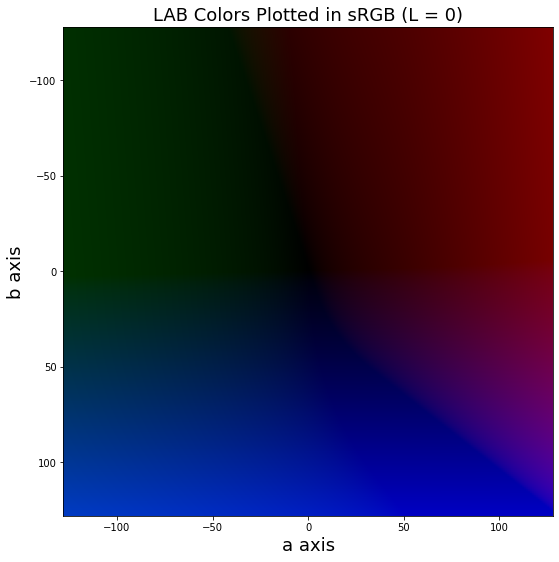

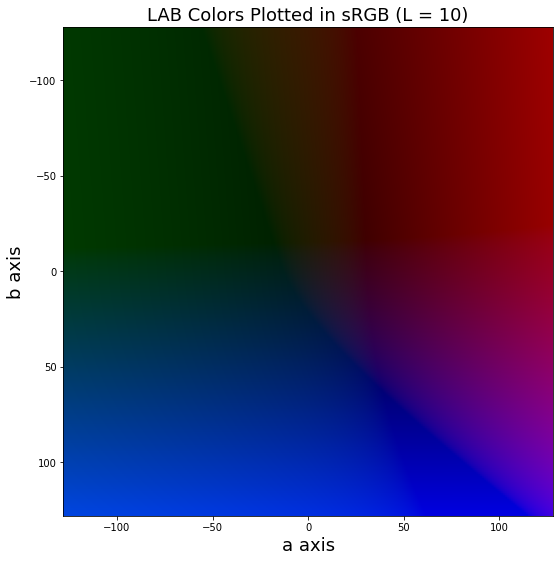

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


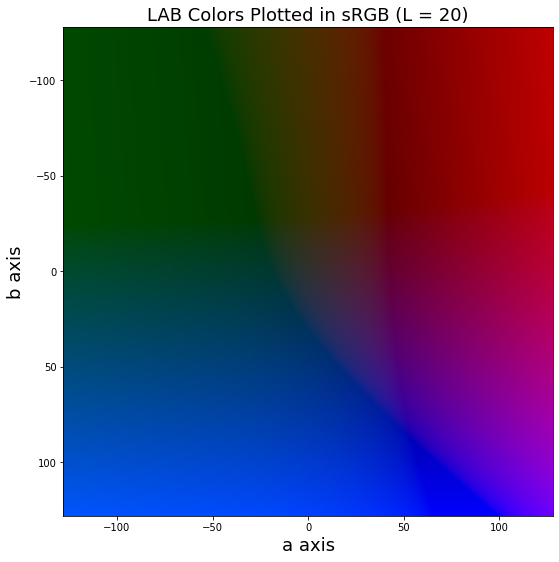

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


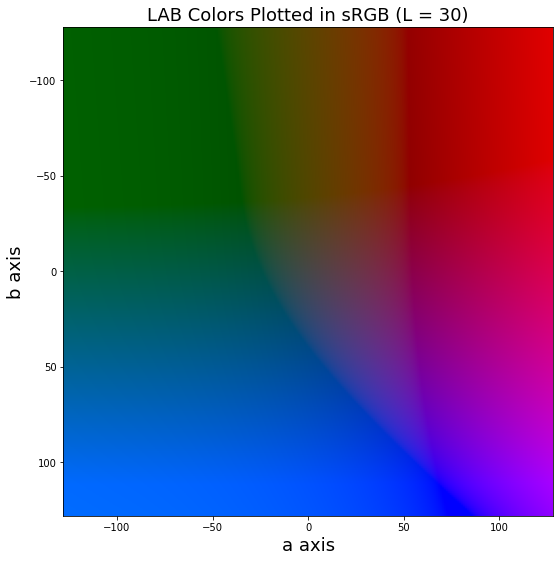

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


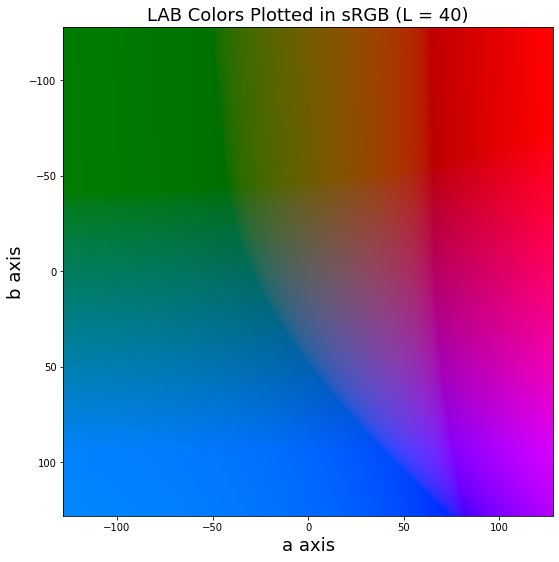

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


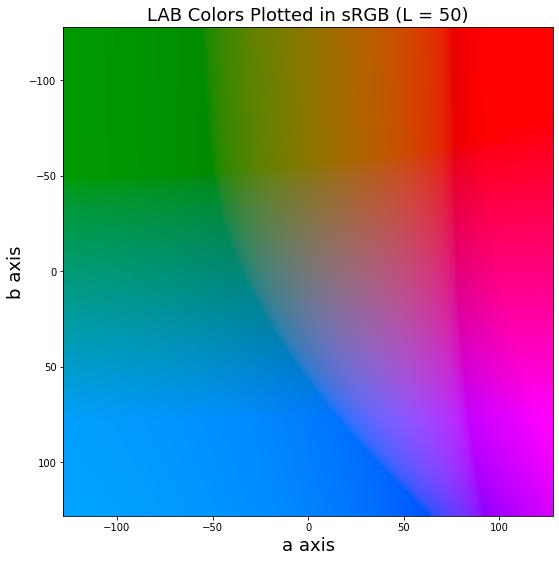

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


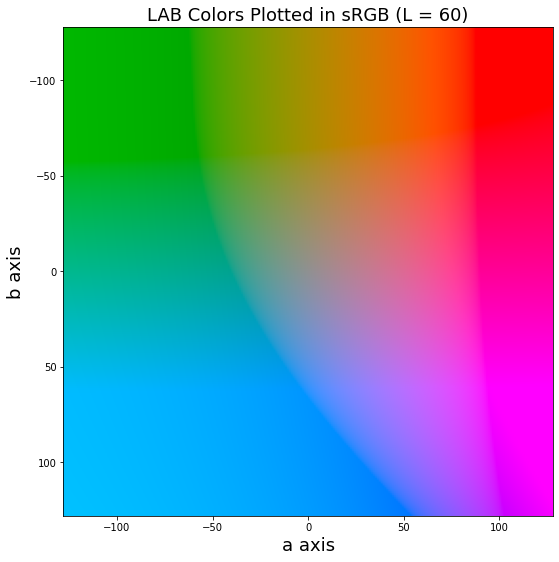

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


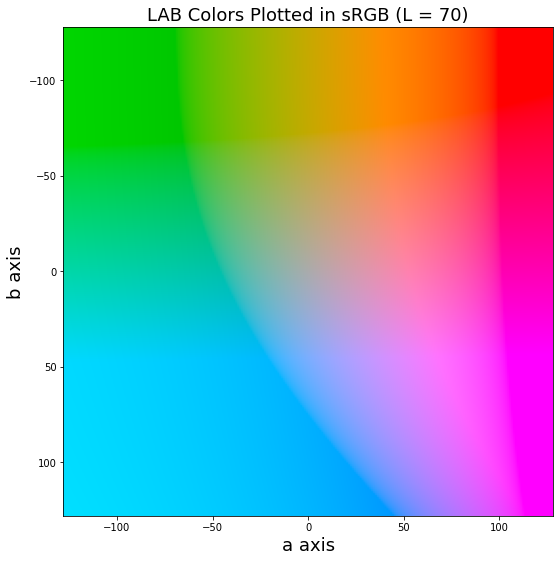

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


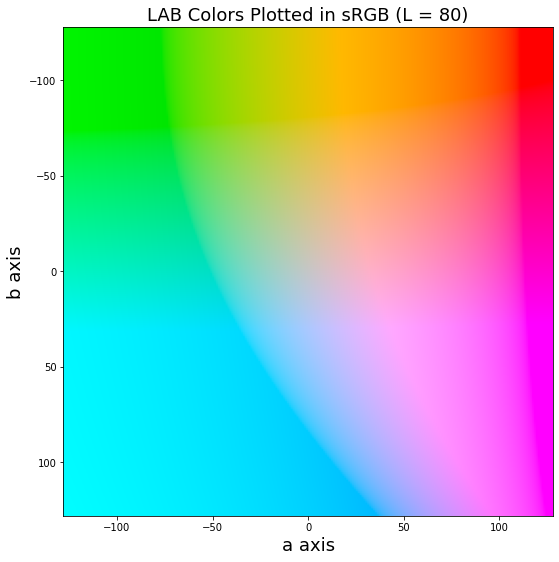

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


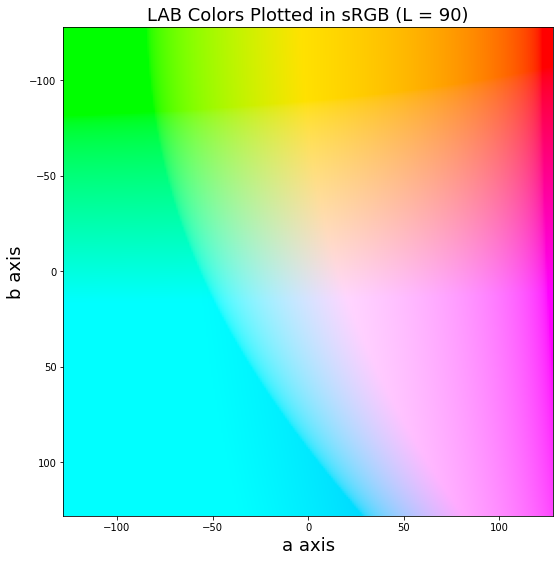

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


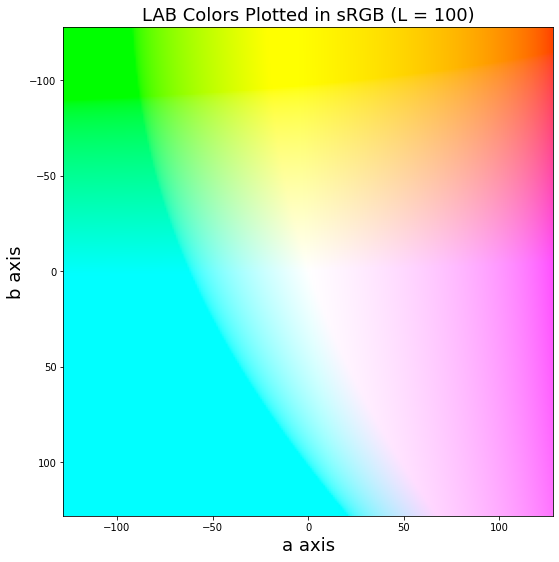

In [178]:
for L, plot_matrix in data.items():
    fig, ax = plt.subplots(figsize=(16, 9))
    ax.imshow(plot_matrix, extent=(-128, 128, 128, -128))
    ax.set_title(f"LAB Colors Plotted in sRGB (L = {L})", fontsize=18)
    ax.set_xlabel("a axis", fontsize=18)
    ax.set_ylabel("b axis", fontsize=18)
    plt.show()
    plt.close()

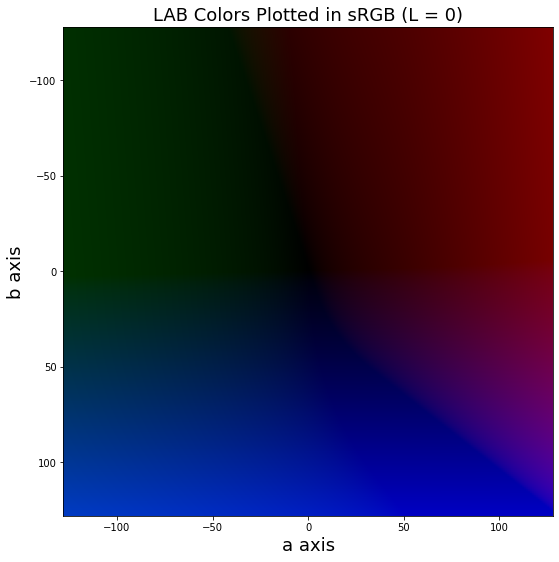

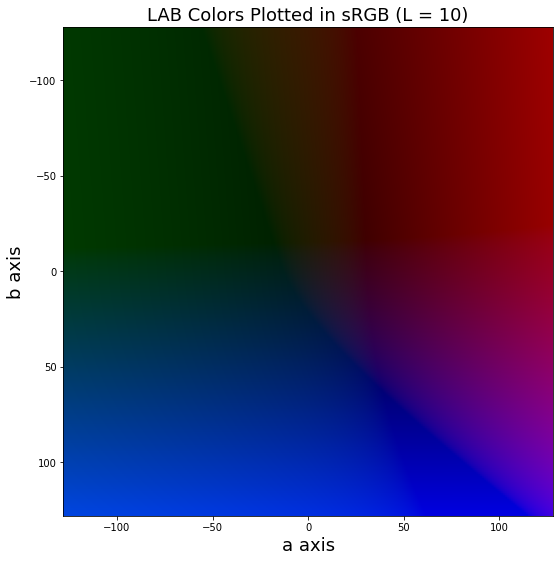

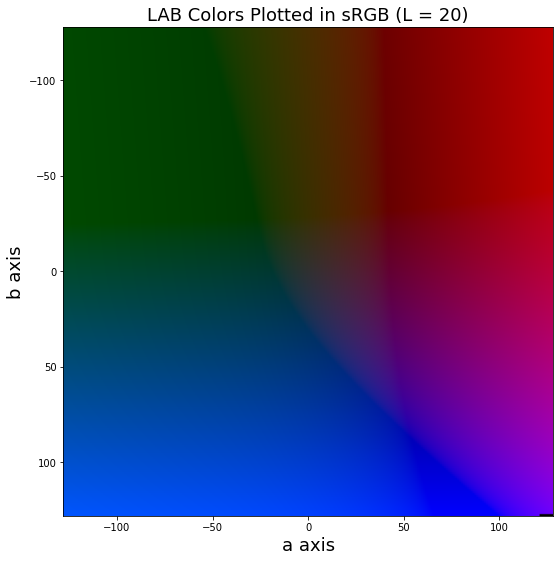

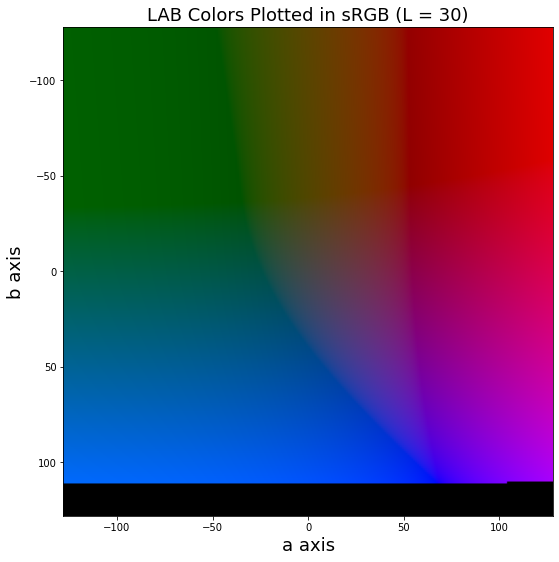

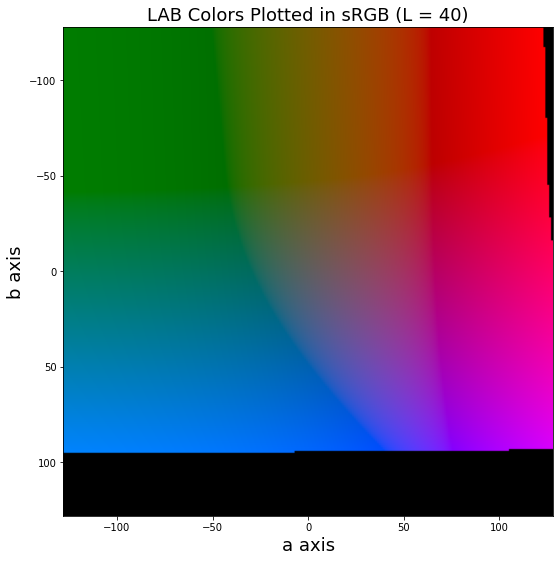

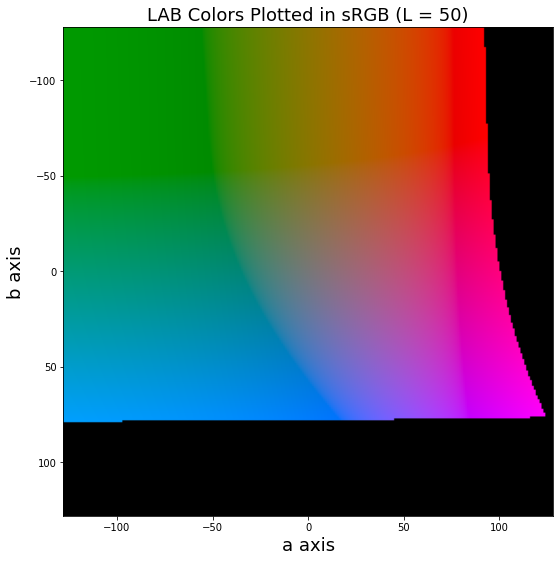

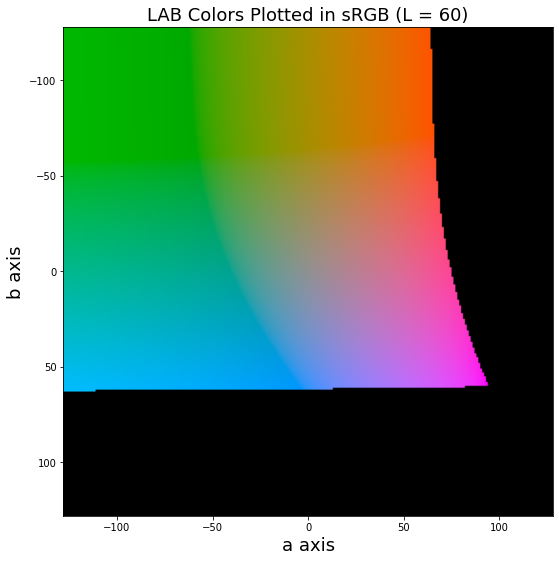

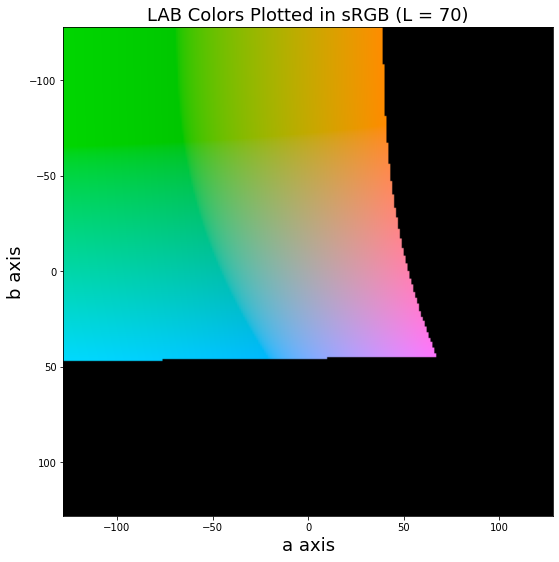

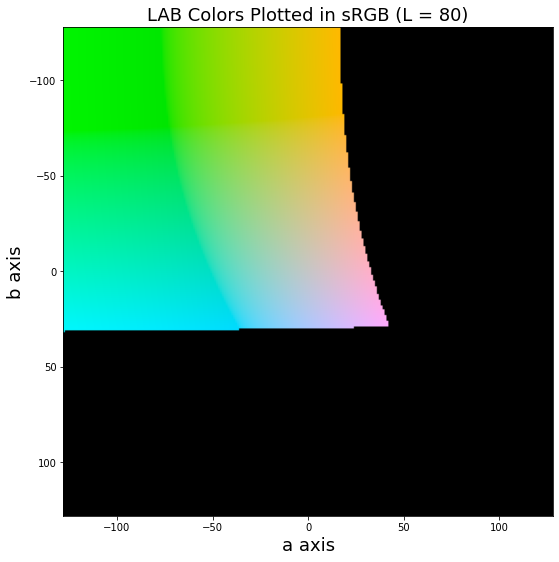

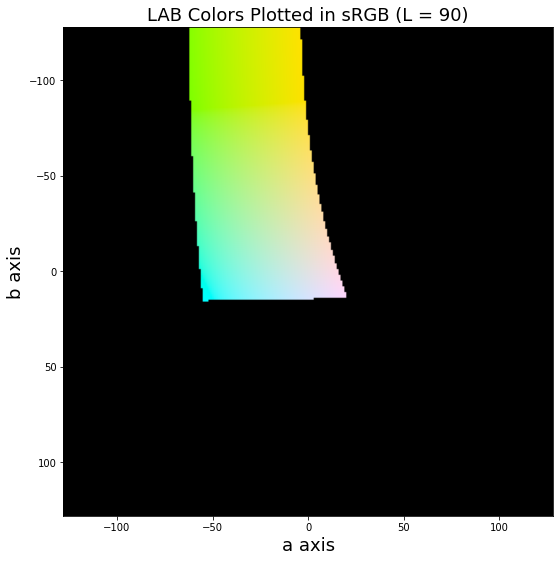

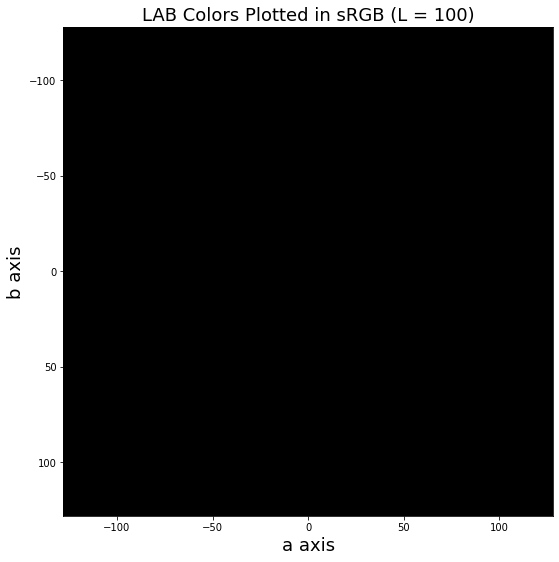

In [177]:
for L, plot_matrix in data_filt.items():
    fig, ax = plt.subplots(figsize=(16, 9))
    ax.imshow(plot_matrix, extent=(-128, 128, 128, -128))
    ax.set_title(f"LAB Colors Plotted in sRGB (L = {L})", fontsize=18)
    ax.set_xlabel("a axis", fontsize=18)
    ax.set_ylabel("b axis", fontsize=18)
    plt.show()
    plt.close()